In [1]:
import numpy as np 
from IPython.display import Image 
import branca.colormap as cm
import pandas as pd 
import seaborn as sns 
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
import matplotlib.pyplot as pl
from sklearn.preprocessing import LabelEncoder
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc
import matplotlib
import imblearn
import folium
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
datapsd = pd.read_csv("/kaggle/input/telco-psd/Telco.csv")

In [4]:
datapsd.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [5]:
from pandas_profiling import ProfileReport

In [6]:
kucing = ['CustomerID','Count','Country','State','City','Zip Code','Lat Long','Latitude','Longitude','Churn Value','Churn Score','CLTV','Churn Reason']
data = datapsd.drop(kucing,axis=1)

In [7]:
profile = ProfileReport(data)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Ternyata ada kesalahan pada data yaitu Total_Charges menjadi kategorik sehingga perlu dibersihkan terlebih dahulu

In [8]:
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')

In [9]:
data.isnull().sum()

Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn Label           0
dtype: int64

Mengatasi Total Charges yang Missing value

In [10]:
#Mengatasi Total Charges yang Missing value
data['calc_charges'] = data['Monthly Charges'] * data['Tenure Months']
data['diff_in_charges'] = data['Total Charges'] - data['calc_charges']

In [11]:
#Input Missing Value
data['Total Charges'] = np.where(data['Total Charges'].isna() == True,data['calc_charges'], data['Total Charges'])

In [12]:
#drop untuk mengeluarkan column yang tidak berguna
data = data.drop(['calc_charges','diff_in_charges'], axis=1)

# Preparing Data For The Model

In [13]:
data['Churn Label'].replace(to_replace='Yes', value=1, inplace=True)
data['Churn Label'].replace(to_replace='No',  value=0, inplace=True)

In [14]:
data[['Monthly Charges', 'Total Charges']].corr()

,Monthly Charges,Total Charges
Monthly Charges,1.000000,0.651174
Total Charges,0.651174,1.000000


Ternyata ada Imbalance data 

In [15]:
data.groupby('Churn Label')['Churn Label'].count()

Churn Label
0    5174
1    1869
Name: Churn Label, dtype: int64

In [16]:
over = SMOTE(sampling_strategy = 1)

X = data.drop("Churn Label", axis = 1)
y = data['Churn Label']

In [17]:
X

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50
7040,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90
7041,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45


In [18]:
# import category encoders

from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()


X['Gender'] = encoder.fit_transform(X['Gender'])
X['Senior Citizen'] = encoder.fit_transform(X['Senior Citizen'])
X['Partner'] = encoder.fit_transform(X['Partner'])
X['Dependents'] = encoder.fit_transform(X['Dependents'])
X['Phone Service'] = encoder.fit_transform(X['Phone Service'])
X['Multiple Lines'] = encoder.fit_transform(X['Multiple Lines'])
X['Internet Service'] = encoder.fit_transform(X['Internet Service'])
X['Online Security'] = encoder.fit_transform(X['Online Security'] )
X['Online Backup'] = encoder.fit_transform(X['Online Backup'])
X['Device Protection'] = encoder.fit_transform(X['Device Protection'])
X['Tech Support'] = encoder.fit_transform(X['Tech Support'])
X['Streaming TV'] = encoder.fit_transform(X['Streaming TV'])
X['Streaming Movies'] = encoder.fit_transform(X['Streaming Movies'])
X['Contract'] = encoder.fit_transform(X['Contract'])
X['Paperless Billing'] = encoder.fit_transform(X['Paperless Billing'])
X['Payment Method'] = encoder.fit_transform(X['Payment Method'])

In [19]:
X,y = over.fit_resample(X,y)

# Modelling

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [22]:
def model(method, X_train, y_train, X_test, y_test):
    # Train the model
    method.fit(X_train, y_train)
    
    # Make predictions on test data and calculate confusion matrix
    predictions = method.predict(X_test)
    c_matrix = confusion_matrix(y_test, predictions)
    
    # Calculate label percentages and create label strings with counts and percentages
    percentages = (c_matrix / np.sum(c_matrix, axis=1)[:, np.newaxis]).round(2) * 100
    labels = [[f"{c_matrix[i, j]} ({percentages[i, j]:.2f}%)" for j in range(c_matrix.shape[1])] for i in range(c_matrix.shape[0])]
    labels = np.asarray(labels)
    
    # Plot confusion matrix with labeled counts and percentages
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')
    
    # Evaluate model performance and print results
    print("ROC AUC: ", '{:.2%}'.format(roc_auc_score(y_test, predictions)))
    print("Model accuracy: ", '{:.2%}'.format(accuracy_score(y_test, predictions)))
    print(classification_report(y_test, predictions))

Menggunakan Random Forest

In [23]:
# Mencari Features yang berpengaruh dengan random forest model
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set
clf.fit(X_train, y_train)

y_pred_100 = clf.predict(X_test)



# Check accuracy score 

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.8471


In [24]:
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

Contract             0.134700
Total Charges        0.134281
Monthly Charges      0.131163
Tenure Months        0.114788
Online Security      0.086540
Tech Support         0.076494
Dependents           0.061715
Payment Method       0.040885
Device Protection    0.030647
Online Backup        0.029382
Internet Service     0.025126
Partner              0.024708
Gender               0.019620
Multiple Lines       0.019604
Paperless Billing    0.017742
Streaming Movies     0.015982
Streaming TV         0.015436
Senior Citizen       0.014898
Phone Service        0.006291
dtype: float64

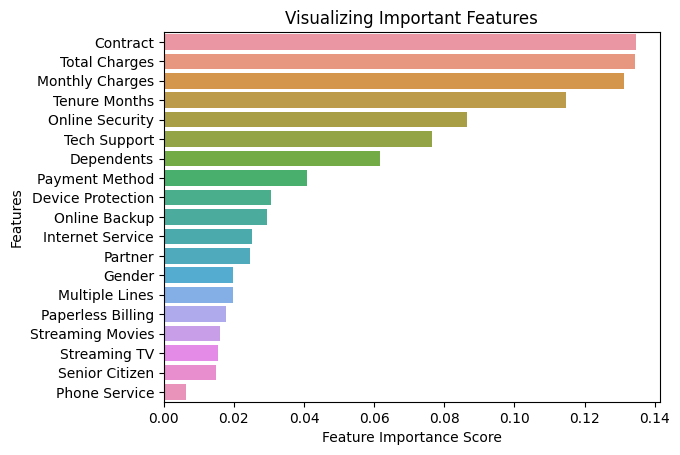

In [25]:
# Creating a seaborn bar plot

sns.barplot(x=feature_scores, y=feature_scores.index)



# Add labels to the graph

pl.xlabel('Feature Importance Score')

pl.ylabel('Features')



# Add title to the graph
pl.title("Visualizing Important Features")



# Visualize the graph

pl.show()

In [26]:
Xi = X.drop(['Online Backup','Device Protection','Internet Service','Partner','Gender','Multiple Lines','Paperless Billing','Streaming TV','Streaming Movies','Senior Citizen','Phone Service'], axis=1)
yi = y

In [27]:
Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi, test_size = 0.33, random_state = 42)

In [28]:
# instantiate the classifier with n_estimators = 100

clf = RandomForestClassifier(n_estimators=120,random_state=0)

# fit the model to the training set

clf.fit(Xi_train, yi_train)


# Predict on the test set results

y_pred = clf.predict(Xi_test)



# Check accuracy score 

print('Model accuracy score with doors variable removed : {0:0.4f}'. format(accuracy_score(yi_test, y_pred)))

Model accuracy score with doors variable removed : 0.8343


In [29]:
clf = RandomForestClassifier(n_estimators=120,random_state=0)

ROC AUC:  83.42%
Model accuracy:  83.43%
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1700
           1       0.82      0.85      0.84      1715

    accuracy                           0.83      3415
   macro avg       0.83      0.83      0.83      3415
weighted avg       0.83      0.83      0.83      3415



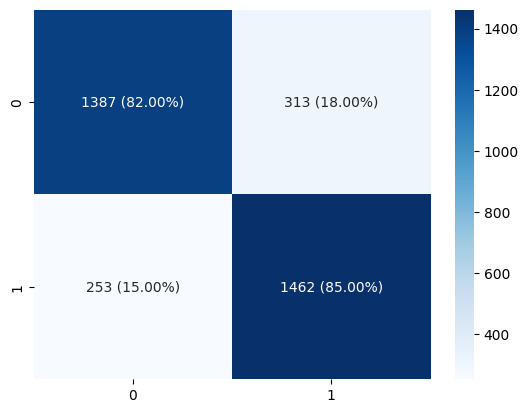

In [30]:
model(clf,Xi_train,yi_train,Xi_test,yi_test)

# EDA

In [31]:
fig = px.bar(datapsd.groupby(['Payment Method',
                                                'Churn Label'])['CustomerID'].count().reset_index(),
             x="CustomerID",
             y="Payment Method", 
             color="Churn Label", 
             text = 'CustomerID'
            )
fig.show()

In [32]:
fig = px.bar(datapsd.groupby(['Churn Reason'])['CustomerID'].count().reset_index().sort_values('CustomerID',
                                                                                    ascending=False),
             x='Churn Reason',
             y='CustomerID', 
             color = 'CustomerID',
             text = 'CustomerID')
fig.show()

In [33]:
fig = px.pie(datapsd.groupby('Churn Label')['CustomerID'].nunique().reset_index(), 
             values='CustomerID', 
             names='Churn Label')
fig.show()

In [34]:
fig = px.histogram(datapsd, x="Tenure Months", color="Churn Label")
fig.show()

In [35]:
fig = px.pie(datapsd.groupby(['Contract','Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
            names='Contract',
            facet_col = 'Churn Label',
            title = 'Churn rate by contract type')
            
fig.show()

In [36]:
fig = px.histogram(data, x="Total Charges", color="Churn Label")
fig.show()

In [37]:
fig = px.histogram(datapsd, x="Monthly Charges", color="Churn Label")
fig.show()

In [38]:
fig = px.pie(datapsd.groupby(['Tech Support','Churn Label'])['CustomerID'].count().reset_index(), 
             values='CustomerID', 
             facet_col = 'Churn Label',
             hole = .5,
             names='Tech Support',
            title = 'Tech support option and churn')
fig.show()

In [39]:
# import category encoders

from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()

cd = data

cd['Gender'] = encoder.fit_transform(cd['Gender'])
cd['Senior Citizen'] = encoder.fit_transform(cd['Senior Citizen'])
cd['Partner'] = encoder.fit_transform(cd['Partner'])
cd['Dependents'] = encoder.fit_transform(cd['Dependents'])
cd['Phone Service'] = encoder.fit_transform(cd['Phone Service'])
cd['Multiple Lines'] = encoder.fit_transform(cd['Multiple Lines'])
cd['Internet Service'] = encoder.fit_transform(cd['Internet Service'])
cd['Online Security'] = encoder.fit_transform(cd['Online Security'] )
cd['Online Backup'] = encoder.fit_transform(cd['Online Backup'])
cd['Device Protection'] = encoder.fit_transform(cd['Device Protection'])
cd['Tech Support'] = encoder.fit_transform(cd['Tech Support'])
cd['Streaming TV'] = encoder.fit_transform(cd['Streaming TV'])
cd['Streaming Movies'] = encoder.fit_transform(cd['Streaming Movies'])
cd['Contract'] = encoder.fit_transform(cd['Contract'])
cd['Paperless Billing'] = encoder.fit_transform(cd['Paperless Billing'])
cd['Payment Method'] = encoder.fit_transform(cd['Payment Method'])

In [40]:
fig = px.bar(cd.corr()['Churn Label'].sort_values(ascending = False),
             color = 'value')
fig.show()